# Seizure Detection and Prediction by Parallel Memristive Convolutional Neural Networks
<br>


In [1]:
import numpy as np
import statistics
import pyedflib
# import mne
import math

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

from IPython.display import display, Markdown  #display(Markdown("# Hello World!"))


In [2]:
# %matplotlib notebook            # Interactive website
plt.style.use('ggplot')

In [3]:
display(Markdown('[All signals were sampled at 256 samples per second with 16-bit resolution]\
(https://www.researchgate.net/figure/23-scalp-EEG-channels-in-the-CHB-MIT-recordings_tbl1_356885415)'))

# File Name: chb07_13.edf
# File Start Time: 11:46:29
# File End Time: 12:48:35
# Number of Seizures in File: 1
# Seizure 1 Start Time: 3285 seconds
# Seizure 1 End Time: 3381 seconds

sample_rate = 256

[All signals were sampled at 256 samples per second with 16-bit resolution](https://www.researchgate.net/figure/23-scalp-EEG-channels-in-the-CHB-MIT-recordings_tbl1_356885415)

In [4]:
def readedf(path):
    f = pyedflib.EdfReader(path)
    n = f.signals_in_file
    signal_labels = f.getSignalLabels()
    sigbufs = np.zeros((n, f.getNSamples()[0]))
    for i in np.arange(n):
        sigbufs[i,:] = f.readSignal(i)
    return sigbufs

In [5]:
path = './chb07_13.edf'
chb07_13 = readedf(path)
path = './chb07_02.edf'
chb07_02 = readedf(path)
chb07_13.shape, chb07_02.shape

((23, 953856), (23, 3686400))

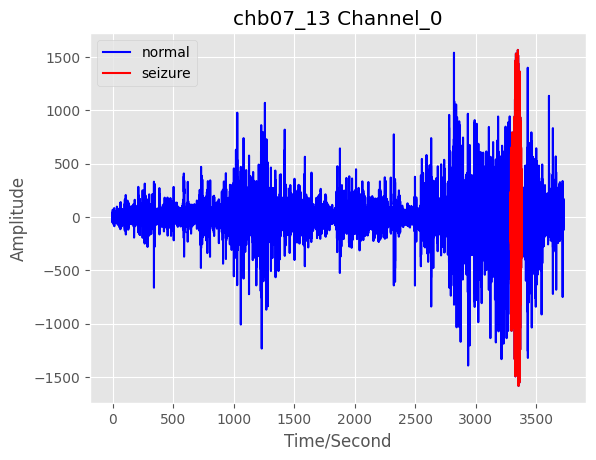

In [6]:
# File Name: chb07_13.edf
# File Start Time: 11:46:29
# File End Time: 12:48:35
# Number of Seizures in File: 1
# Seizure 1 Start Time: 3285 seconds
# Seizure 1 End Time: 3381 seconds

timeline = np.arange(0,np.size(chb07_13,axis=1)/sample_rate, 1/sample_rate) # define the time axis
seizure_start = np.where(timeline==3285)[0]  # Seizure START
seizure_end = np.where(timeline==3381)[0]    # Seizure END

plt.figure()
plt.title('chb07_13 Channel_0')
plt.plot(timeline, chb07_13[1,:],'b', label='normal')
plt.plot(timeline[int(seizure_start):int(seizure_end)],chb07_13[1,int(seizure_start):int(seizure_end)],'r', label='seizure')
plt.xlabel('Time/Second')
plt.ylabel('Amplitude')
plt.legend()

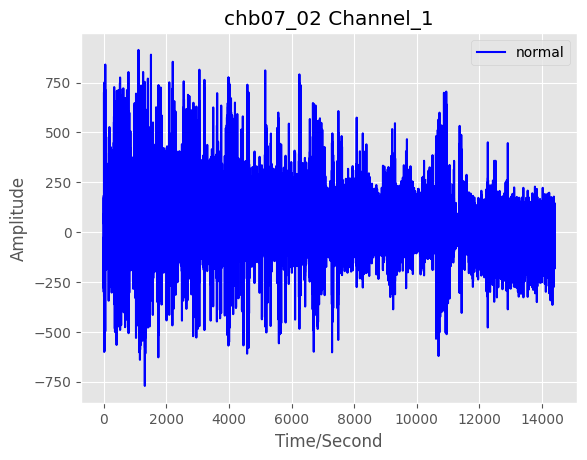

In [7]:
# File Name: chb07_02.edf
# File Start Time: 21:00:13
# File End Time: 25:00:13
# Number of Seizures in File: 0
chb0702_TL = np.arange(0,np.size(chb07_02,axis=1)/sample_rate,1/sample_rate)
plt.figure()
plt.title('chb07_02 Channel_1')
plt.plot(chb0702_TL, chb07_02[0,:],'b', label='normal')
plt.xlabel('Time/Second')
plt.ylabel('Amplitude')
plt.legend()

## Test pre_ictal signal

In [8]:
pre_ictal = chb07_13[:,211200:825600]
pre_ict_TL = np.arange(825,3225,1/sample_rate)

Text(0.5, 1.0, 'Pre-ictal signal')

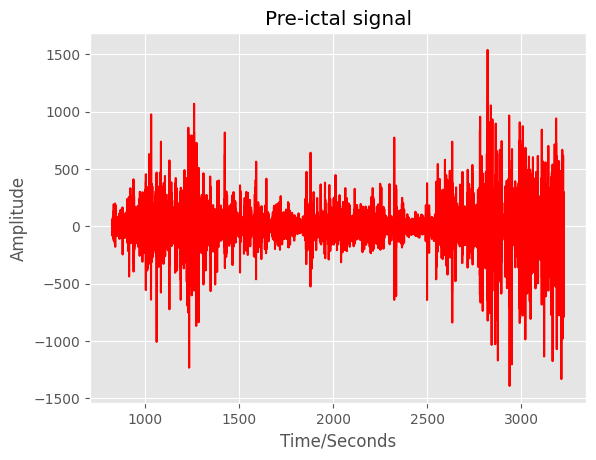

In [9]:
plt.figure()
plt.plot(pre_ict_TL, pre_ictal[1,:],c='r')
plt.xlabel('Time/Seconds')
plt.ylabel('Amplitude')
plt.title('Pre-ictal signal')

Text(0.5, 1.0, 'inter-ictal signal')

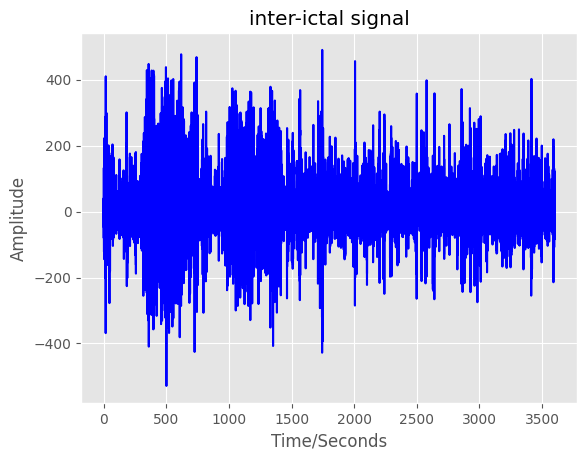

In [10]:
inter_ictal = chb07_02[:,0:60*60*sample_rate]                       # 60 min = 60 * 60 seconds = 60*60*sample_rate points
inter_ict_TL = np.arange(0,3600,1/sample_rate)

# plot figure
plt.figure()
plt.plot(inter_ict_TL, inter_ictal[1,:],c='b')
plt.xlabel('Time/Seconds')
plt.ylabel('Amplitude')
plt.title('inter-ictal signal')

## Mean

In [11]:
def feat_mean(array):
    return np.mean(array)

## Variance

In [12]:
def feat_variance(array):
    return np.var(array, axis=0)

## Skewness

In [13]:
def feat_skewness(array):
    skewness = np.mean((array - np.mean(array))**3) / np.std(array)**3
    return skewness

## Kurtosis

In [14]:
def feat_kurtosis(array):
    kurtosis = np.mean((array - np.mean(array))**4) / np.std(array)**4
    return kurtosis

## Coefficient of variation

In [15]:
def feat_cov(array):
    CoV = (np.std(array)/np.mean(array))
    return CoV

## Median absolute deviation

In [16]:
def feat_mad(array):
    median = np.median(array)
    abs_deviation = np.abs(array-median)
    mad = np.median(abs_deviation)
    return mad

## Root mean square amplitude

In [17]:
def feat_rms(array):
    rms_amplitude = np.sqrt(np.mean(np.square(array)))
    return rms_amplitude

## Shannon entropy

In [18]:
def feat_shannon_entropy(sequence):
    uniqw, inverse = np.unique(sequence, return_inverse=True)
    event_counts = np.bincount(inverse)

    # Calculate probabilities
    total_events = len(sequence)
    event_probabilities = event_counts / total_events

    # Calculate Shannon entropy
    entropy = -np.sum(event_probabilities * np.log2(event_probabilities))
    return entropy

## Features calculate

In [19]:
# array = (signal)
def get_features(array):
    all_features = np.zeros((1,8))
    all_features[0,0] = feat_mean(array)
    all_features[0,1] = feat_variance(array)
    all_features[0,2] = feat_skewness(array)
    all_features[0,3] = feat_kurtosis(array)
    all_features[0,4] = feat_cov(array)
    all_features[0,5] = feat_mad(array)
    all_features[0,6] = feat_rms(array)
    all_features[0,7] = feat_shannon_entropy(array)
    return all_features

## Sliding windows

In [20]:
# the unit of window size and window step is points(second * sample_rate)
# array = (signal)
def slide_windows(array, window_size, window_step):
    array_len = np.size(array)
    num_window = math.floor((array_len-window_size)/window_step)
    output = np.zeros((num_window, window_size))
    for i in range(num_window):
        output[i,:] = array[0 + window_step*i:window_size + window_step*i]
    return output

### Using sliding window segment signal for all channels

In [21]:
def channel_slide_windows(array, window_size, window_step): # array's format should be [#channel by #points]
    for i in range(np.size(array,axis=0)):
        if i == 0:
            temp = slide_windows(array = array[0,:], window_size= window_size,
                                window_step = window_step)
            output = np.zeros((np.size(array,axis=0), temp.shape[0], temp.shape[1]))
            output[i,:,:] = temp
        else:
            output[i,:,:] = slide_windows(array = array[i,:], window_size= window_size,
                                    window_step = window_step)
    return output # (#channel, #window, signal)

In [22]:
pre_ictal_window = channel_slide_windows(pre_ictal, 
                      window_size=64*sample_rate, 
                      window_step=32*sample_rate)

inter_ictal_window = channel_slide_windows(inter_ictal, 
                      window_size=64*sample_rate, 
                      window_step=32*sample_rate)

## Plot random window and channel graphs

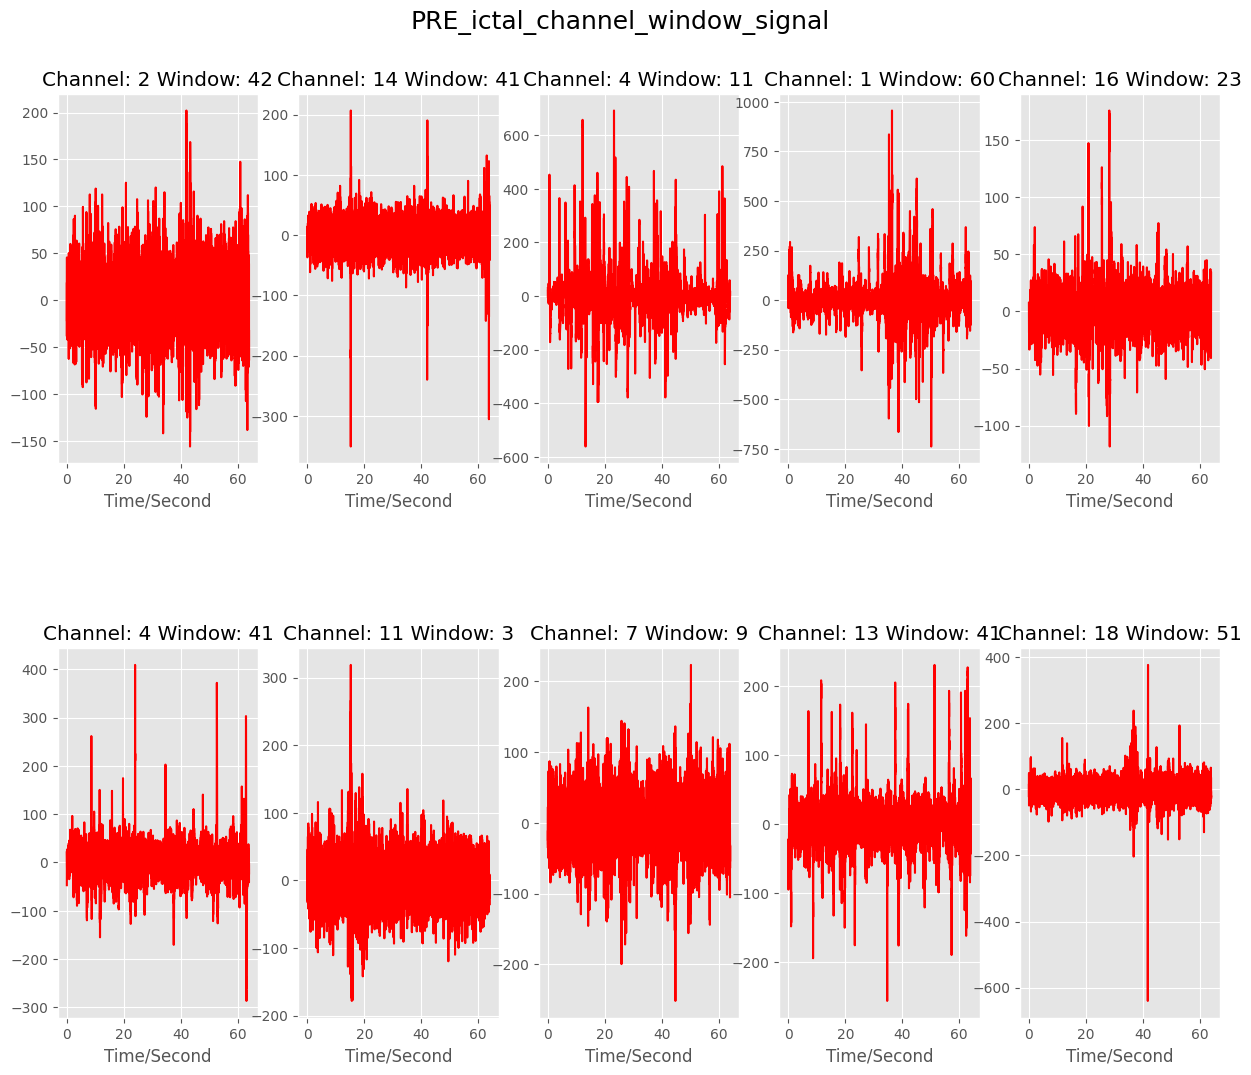

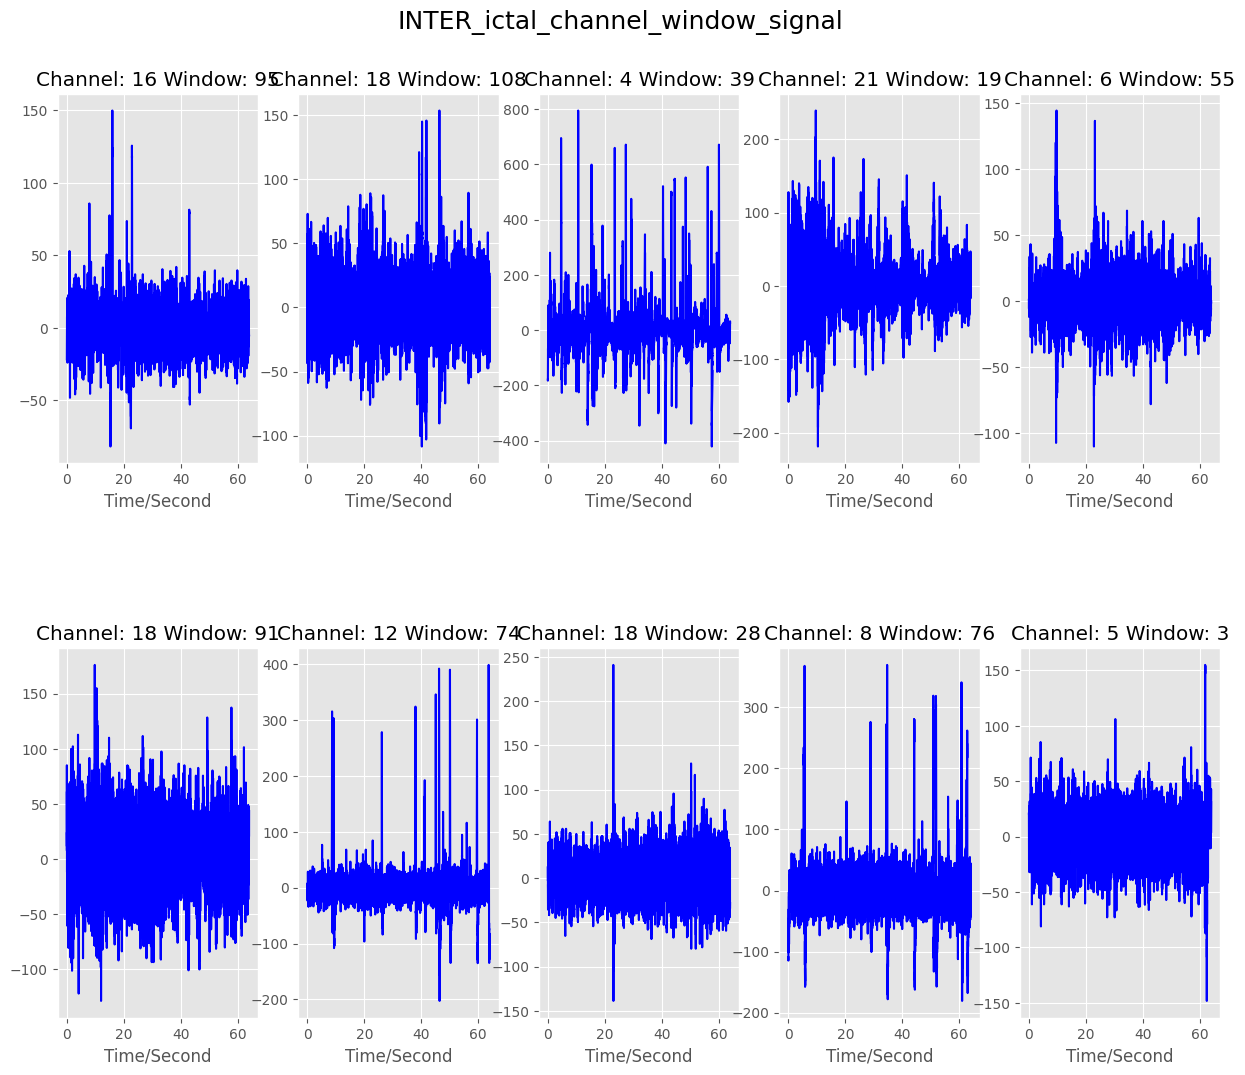

In [23]:
# Create 'pre_ictal_window_index' and 'inter_ictal_window_index'
pre_channel_index = np.random.randint(low=0, high=(np.size(pre_ictal_window,axis=0))-1, size=10)
inter_channel_index = np.random.randint(low=0, high=(np.size(inter_ictal_window, axis=0))-1, size=10)

pre_window_index = np.random.randint(low=0,high=(np.size(pre_ictal_window,axis=1))-1, size=10)
inter_window_index = np.random.randint(low=0,high=(np.size(inter_ictal_window,axis=1))-1,size=10)
# indexs start from zero, for example channel index from 0 to 22

# Create fig 1
plt.figure(figsize=(15, 12))
plt.subplots_adjust(hspace=0.5)
plt.suptitle("PRE_ictal_channel_window_signal", fontsize=18, y=0.95)
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.title('Channel: ' + str(pre_channel_index[i])+
             ' Window: ' + str(pre_window_index[i]))
    plt.plot(np.arange(0,64,1/sample_rate), pre_ictal_window[pre_channel_index[i], pre_window_index[i],:],
            c='r')
    plt.xlabel('Time/Second')

# Create fig 2    
plt.figure(figsize=(15, 12))
plt.subplots_adjust(hspace=0.5)
plt.suptitle("INTER_ictal_channel_window_signal", fontsize=18, y=0.95)
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.title('Channel: ' + str(inter_channel_index[i])+
             ' Window: ' + str(inter_window_index[i]))
    plt.plot(np.arange(0,64,1/sample_rate), inter_ictal_window[inter_channel_index[i], inter_window_index[i],:],
            c='b')
    plt.xlabel('Time/Second')

# ---------------------------------------------------------------------------------------------------------------------------------------
# CALCULATE FEATURES
pre_window_feature = np.zeros((np.size(pre_window_index), 8))   #   (# selected window * # features)
inter_window_feature = np.zeros((np.size(inter_window_index), 8))



In [24]:
# CALCULATE FEATURES
pre_ictal_window_features = np.zeros((np.size(pre_ictal_window,axis=0), 
                                     np.size(pre_ictal_window,axis=1),
                                     8))
inter_ictal_window_features = np.zeros((np.size(inter_ictal_window,axis=0),
                                       np.size(inter_ictal_window, axis=1),
                                       8))

# calculate pre_ictal features
for i in range(np.size(pre_ictal_window,axis=0)):
    for j in range(np.size(pre_ictal_window, axis=1)):
        pre_ictal_window_features[i,j,:] = get_features(pre_ictal_window[i,j,:])

# calculate inter_ictal feature
for i in range(np.size(inter_ictal_window, axis=0)):
    for j in range(np.size(inter_ictal_window, axis=1)):
        inter_ictal_window_features[i,j,:] = get_features(inter_ictal_window[i,j,:])

## Plot box graph X: 23 Channel Y: # of windows

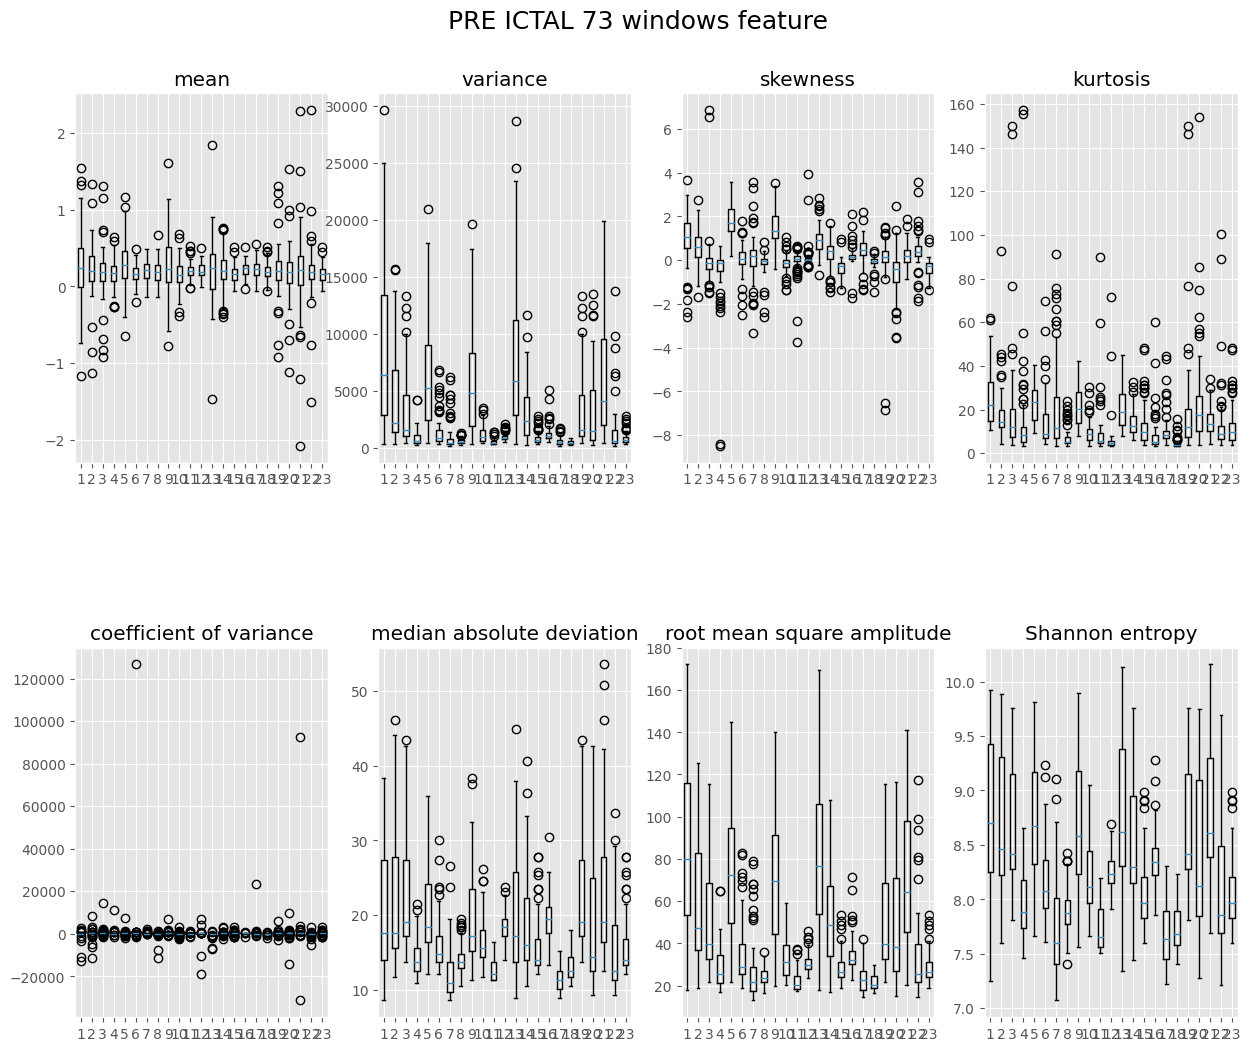

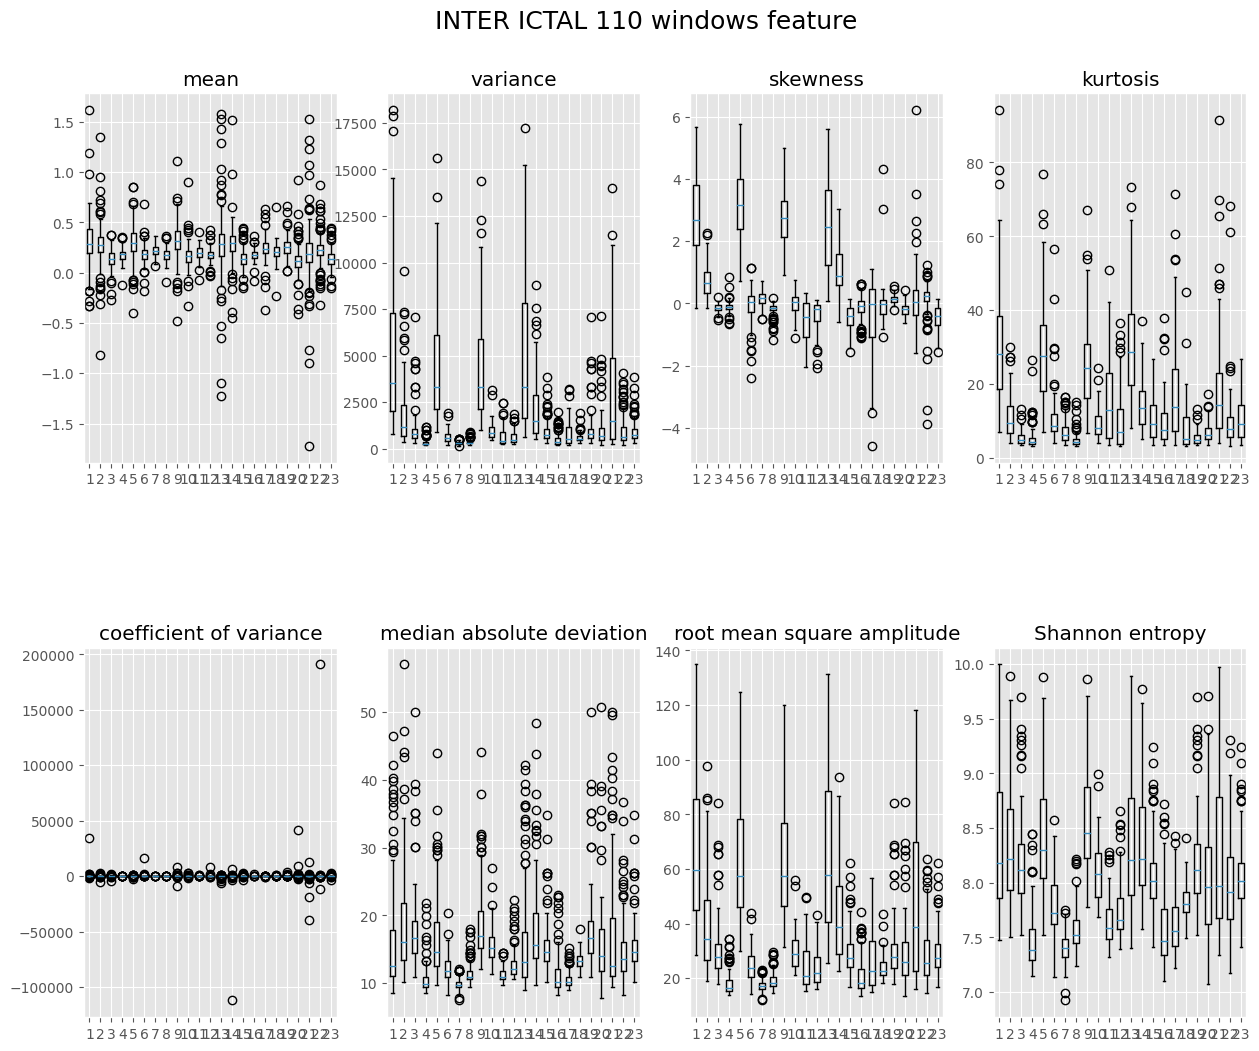

In [25]:
# Create format of subplot
features_title = ['mean', 'variance','skewness', 'kurtosis', 'coefficient of variance',
                 'median absolute deviation', 'root mean square amplitude', 'Shannon entropy' ]
plt.figure(figsize=(15, 12))
plt.subplots_adjust(hspace=0.5)
plt.suptitle("PRE ICTAL 73 windows feature", fontsize=18, y=0.95)
for i in range(8):
    plt.subplot(2,4,i+1)
    plt.title(features_title[i])
    data_list = []
    for j in range(np.size(pre_ictal_window_features, axis=0)):
        data_list.append(pre_ictal_window_features[j,:,i])
    plt.boxplot(data_list)

plt.figure(figsize=(15, 12))
plt.subplots_adjust(hspace=0.5)
plt.suptitle("INTER ICTAL 110 windows feature", fontsize=18, y=0.95)
for i in range(8):
    plt.subplot(2,4,i+1)
    plt.title(features_title[i])
    data_list = []
    for j in range(np.size(inter_ictal_window_features, axis=0)):
        data_list.append(inter_ictal_window_features[j,:,i])
    plt.boxplot(data_list)
# plt.figure()
# plt.boxplot(data_list);

## Plot X: 23 # channels and Y: total # windows

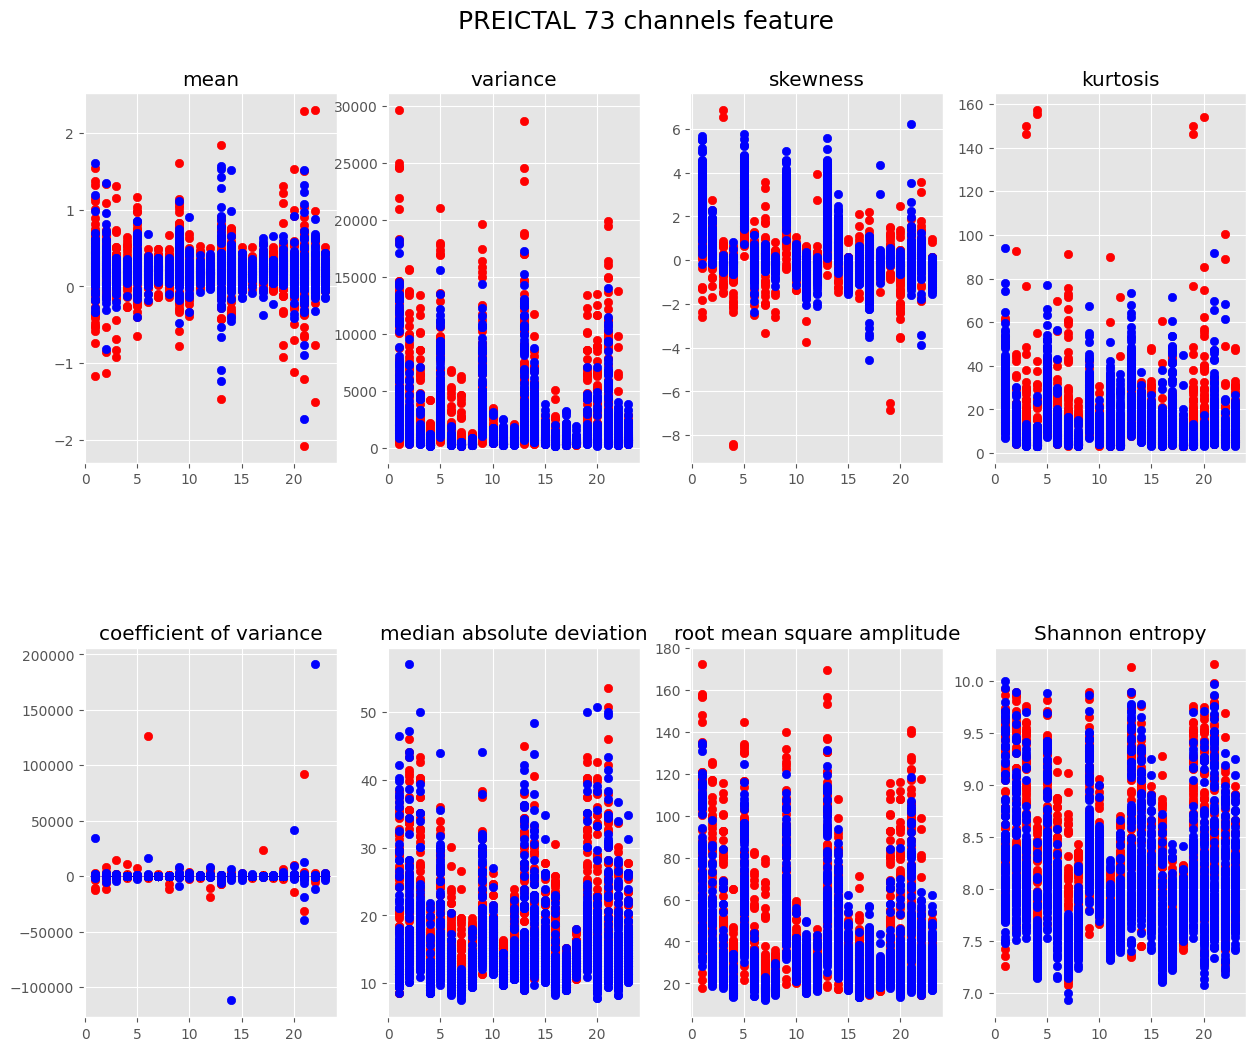

In [26]:
# Create format of subplot
features_title = ['mean', 'variance','skewness', 'kurtosis', 'coefficient of variance',
                 'median absolute deviation', 'root mean square amplitude', 'Shannon entropy' ]
plt.figure(figsize=(15, 12))
plt.subplots_adjust(hspace=0.5)
plt.suptitle("PREICTAL 73 channels feature", fontsize=18, y=0.95)
for i in range(8):
    plt.subplot(2,4,i+1)
    plt.title(features_title[i])
    for j in range(np.size(pre_ictal_window_features, axis=1)):
        plt.scatter(np.arange(1.0,24.0,1.0),pre_ictal_window_features[:,j,i],c='r')
    for k in range(np.size(inter_ictal_window_features, axis=1)):
        plt.scatter(np.arange(1.0,24.0,1.0),inter_ictal_window_features[:,k,i],c='b')
#         plt.legend()

# plt.figure()
# for i in range(np.size(pre_ictal_window_features,axis=1)):
#     plt.scatter(np.arange(1,24,1), pre_ictal_window_features[:,i,7],cmap='Pastel1')

## Plot average scatter points X: # of windows

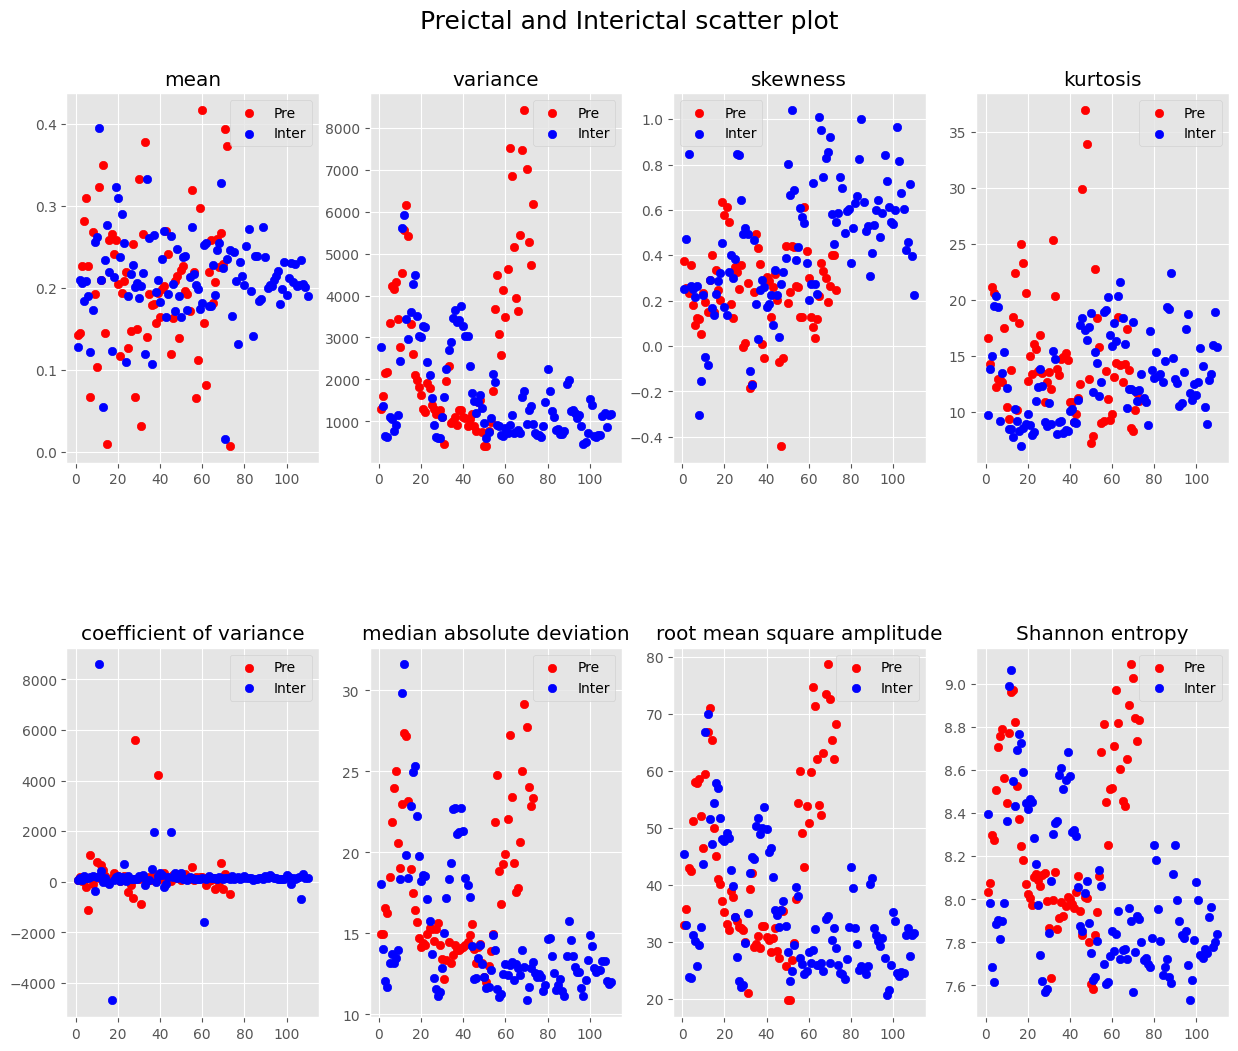

In [27]:
features_title = ['mean', 'variance','skewness', 'kurtosis', 'coefficient of variance',
                 'median absolute deviation', 'root mean square amplitude', 'Shannon entropy' ]
plt.figure(figsize=(15, 12))
plt.subplots_adjust(hspace=0.5)
plt.suptitle("Preictal and Interictal scatter plot", fontsize=18, y=0.95)
for i in range(8):
    plt.subplot(2,4,i+1)
    plt.title(features_title[i])
    plt.scatter(np.arange(1,np.size(pre_ictal_window_features,axis=1)+1,1), np.mean(pre_ictal_window_features,axis=0)[:,i],
                c='r', label='Pre')
    plt.scatter(np.arange(1,np.size(inter_ictal_window_features, axis=1)+1,1), np.mean(inter_ictal_window_features,axis=0)[:,i],
                c = 'b', label='Inter')
    plt.legend();

__________

## Plot features without slide window preprocessing

### Calculating features towards every channel

In [28]:
channel_feat_chb0713 = np.zeros((np.size(pre_ictal,axis=0), 8))    # 23 channel & 8 features
for i in range(np.size(pre_ictal,axis=0)):
    channel_feat_chb0713[i,:] = get_features(pre_ictal[i,:])          # pre-ictal features
    
channel_feat_chb0702 = np.zeros((np.size(inter_ictal,axis=0), 8))    # 23 channel & 8 features
for i in range(np.size(inter_ictal,axis=0)):
    channel_feat_chb0702[i,:] = get_features(inter_ictal[i,:])          # inter-ictal features

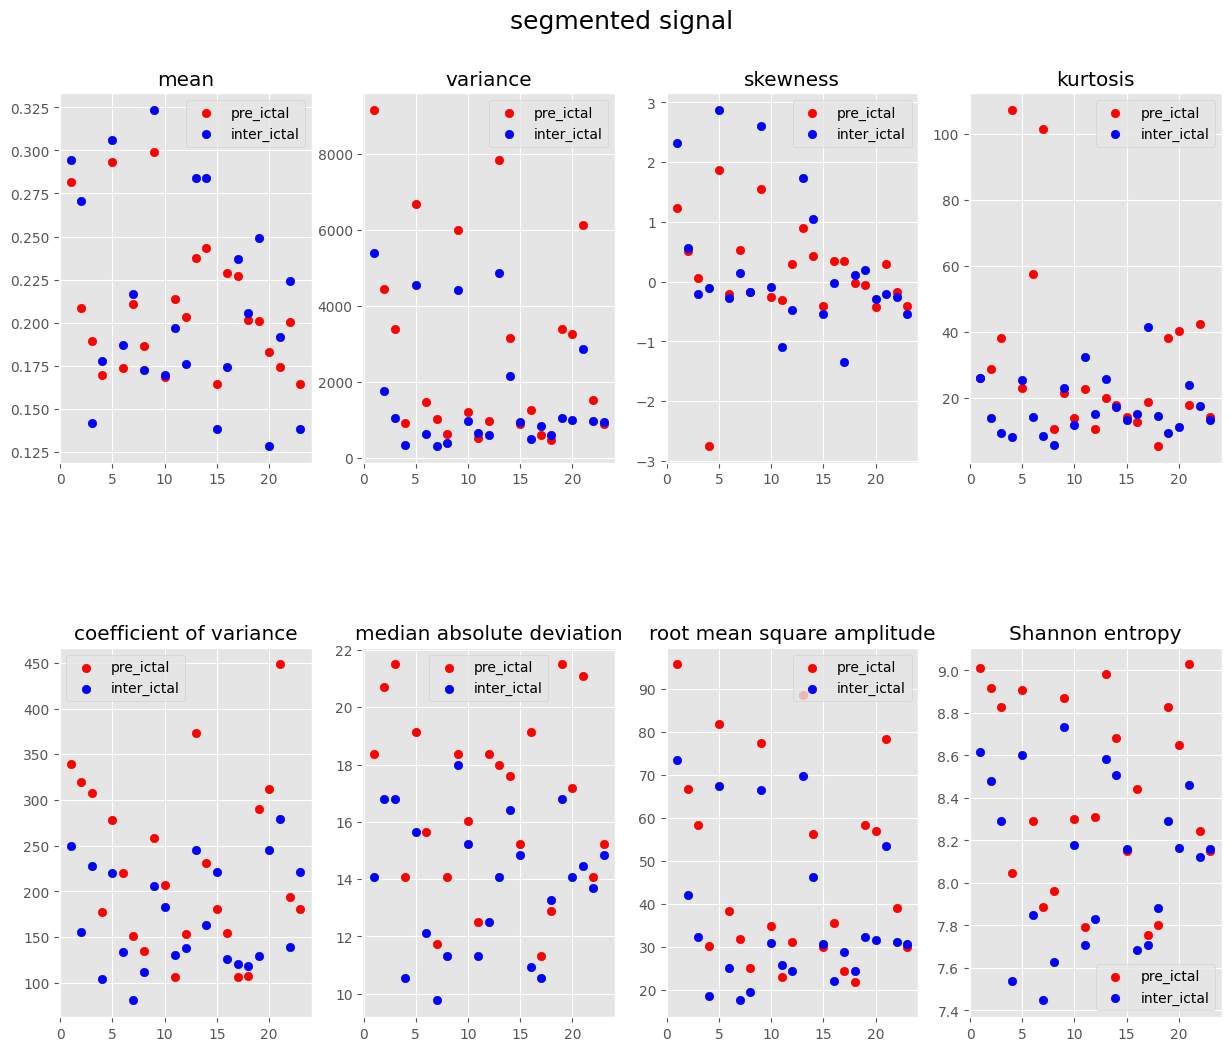

In [29]:
# Create format of subplot
features_title = ['mean', 'variance','skewness', 'kurtosis', 'coefficient of variance',
                 'median absolute deviation', 'root mean square amplitude', 'Shannon entropy' ]
plt.figure(figsize=(15, 12))
plt.subplots_adjust(hspace=0.5)
plt.suptitle("segmented signal", fontsize=18, y=0.95)
for i in range(8):
    plt.subplot(2,4,i+1)
    plt.title(features_title[i])
    plt.scatter(np.arange(1.0,24.0,1.0),channel_feat_chb0713[:,i],c='r',label='pre_ictal')
    plt.scatter(np.arange(1.0,24.0,1.0),channel_feat_chb0702[:,i],c='b',label='inter_ictal')
    plt.legend()

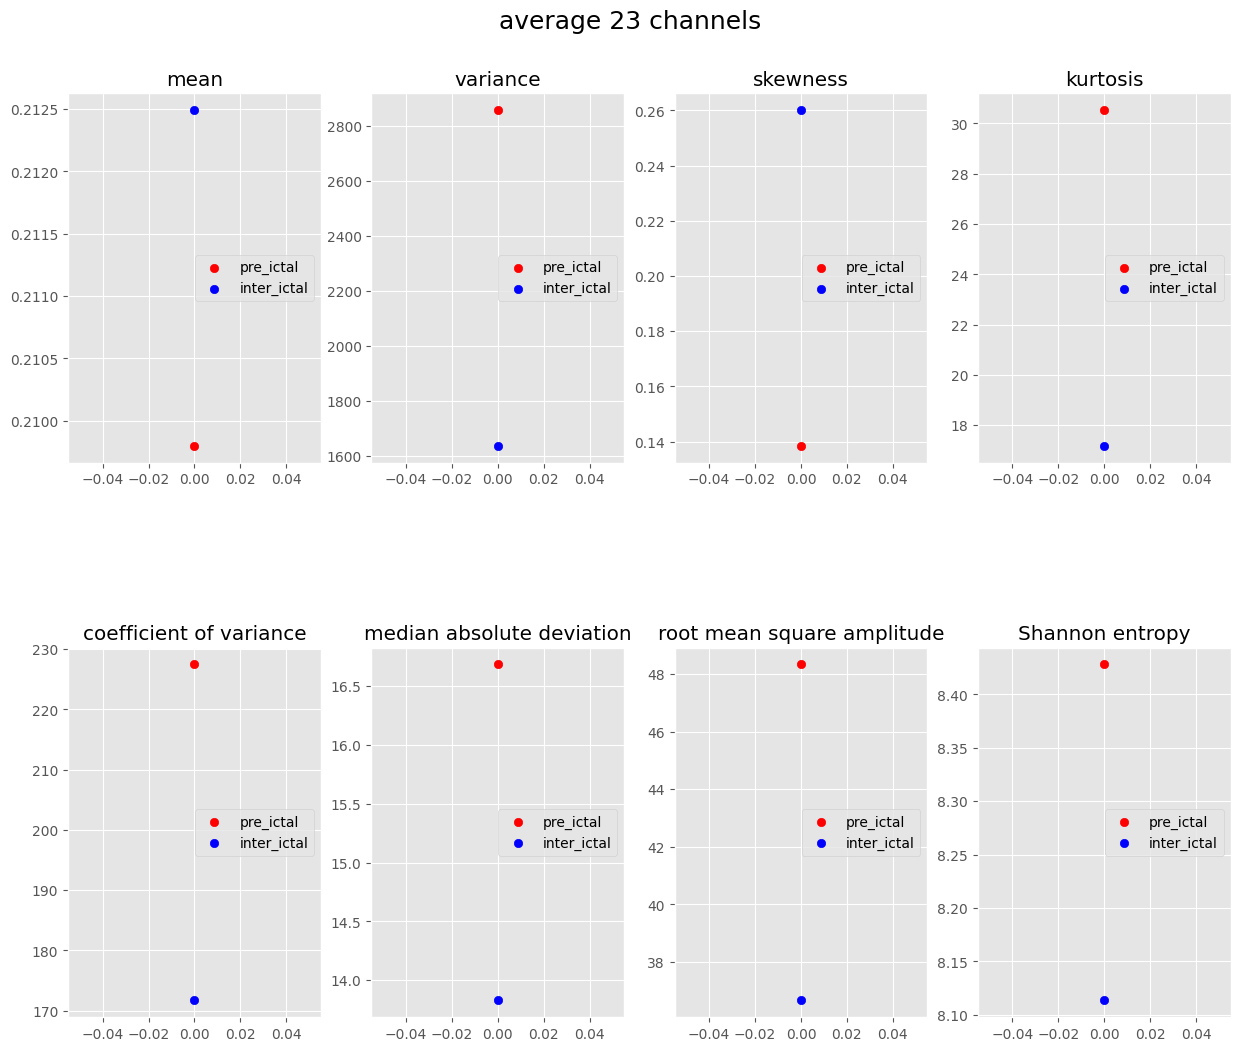

In [30]:
# Create format of subplot
features_title = ['mean', 'variance','skewness', 'kurtosis', 'coefficient of variance',
                 'median absolute deviation', 'root mean square amplitude', 'Shannon entropy' ]
plt.figure(figsize=(15, 12))
plt.subplots_adjust(hspace=0.5)
plt.suptitle("average 23 channels", fontsize=18, y=0.95)
for i in range(8):
    plt.subplot(2,4,i+1)
    plt.title(features_title[i])
    plt.scatter(np.arange(1),np.mean(channel_feat_chb0713[:,i],axis=0),c='r',label='pre_ictal')
    plt.scatter(np.arange(1),np.mean(channel_feat_chb0702[:,i],axis=0),c='b',label='inter_ictal')
    plt.legend(loc='center right')

## Flat dataset

In [31]:
pre_ictal_window_features_t = np.transpose(pre_ictal_window_features,[1,0,2])
inter_ictal_window_features_t = np.transpose(inter_ictal_window_features, [1,0,2])

pre_ictal_window_features_t_flat = pre_ictal_window_features_t.reshape([73,23*8])
inter_ictal_window_features_t_flat = inter_ictal_window_features_t.reshape([110,23*8])

## PCA

In [32]:
from sklearn.decomposition import PCA
n_components = 64
pca = PCA(n_components=n_components)

pre_ictal_pca = pca.fit_transform(pre_ictal_window_features_t_flat)
inter_ictal_pca = pca.fit_transform(inter_ictal_window_features_t_flat)

In [33]:
pre_ictal_pca.shape, inter_ictal_pca.shape

((73, 64), (110, 64))

## Save PREICTAL and INTERICTAL array

In [34]:
np.save('pre_ictal_pca.npy',pre_ictal_pca)
np.save('inter_ictal_pca.npy', inter_ictal_pca)

---------